In [1]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os


In [2]:
train_data_path = r'../INPUT/stacked/final_stack.tif'
train_data = rxr.open_rasterio(train_data_path)

In [3]:
train_path = r'../INPUT/train_point/points/DKS_ranh1.shp'
train_points = gpd.read_file(train_path)
train_points

,class,geometry
0,0,POINT (834777.329 1448071.869)
1,0,POINT (836283.401 1447634.532)
2,1,POINT (834690.976 1448514.776)
3,1,POINT (838911.599 1449906.176)
4,1,POINT (835063.78 1447462.754)
...,...,...
110,0,POINT (835220.237 1447126.627)
111,0,POINT (838438.747 1447833.005)
112,0,POINT (838646.969 1447347.153)
113,0,POINT (837776.474 1447761.044)


In [4]:
# Kiểm tra kiểu dữ liệu của cột class
print(f"Kiểu dữ liệu của cột 'class': {train_points['class'].dtype}")
print(f"Các giá trị unique: {train_points['class'].unique()}")
print(f"Số lượng mỗi class:\n{train_points['class'].value_counts()}")

Kiểu dữ liệu của cột 'class': int64
Các giá trị unique: [0 1]
Số lượng mỗi class:
class
1    63
0    52
Name: count, dtype: int64


In [5]:
# Dữ liệu đã có sẵn class là 0 và 1, chỉ cần đổi tên cột
# 0: Khác, 1: Cao su
train_points['class_label'] = train_points['class'].astype(int)

print(f"✅ Số lượng điểm train: {len(train_points)}")
print(f"Phân bố class:")
print(f"  Class 0 (Khác): {(train_points['class_label'] == 0).sum()}")
print(f"  Class 1 (Cao su): {(train_points['class_label'] == 1).sum()}")

✅ Số lượng điểm train: 115
Phân bố class:
  Class 0 (Khác): 52
  Class 1 (Cao su): 63


In [6]:
# Trích xuất giá trị pixel từ raster tại các điểm train
def extract_pixel_values(raster, points):
    """
    Trích xuất giá trị pixel từ raster tại vị trí các điểm
    """
    # Đảm bảo cùng CRS
    if points.crs != raster.rio.crs:
        points = points.to_crs(raster.rio.crs)
    
    # Lấy tọa độ x, y
    coords = [(point.x, point.y) for point in points.geometry]
    
    # Trích xuất giá trị từ tất cả các band
    pixel_values = []
    for coord in coords:
        # Lấy giá trị tại tọa độ cho tất cả các band
        values = []
        for band in range(raster.shape[0]):
            val = raster[band].sel(x=coord[0], y=coord[1], method='nearest').values
            values.append(val)
        pixel_values.append(values)
    
    return np.array(pixel_values)

print("Trích xuất giá trị pixel từ raster...")
X = extract_pixel_values(train_data, train_points)
y = train_points['class_label'].values

print(f"Shape của X: {X.shape}")
print(f"Shape của y: {y.shape}")
print(f"Số lượng bands: {X.shape[1]}")

Trích xuất giá trị pixel từ raster...
Shape của X: (115, 25)
Shape của y: (115,)
Số lượng bands: 25


In [7]:
# Kiểm tra và loại bỏ các giá trị NaN hoặc Inf
print(f"Số lượng NaN trong X: {np.isnan(X).sum()}")
print(f"Số lượng Inf trong X: {np.isinf(X).sum()}")

# Loại bỏ các mẫu có NaN hoặc Inf
valid_indices = ~(np.isnan(X).any(axis=1) | np.isinf(X).any(axis=1))
X_clean = X[valid_indices]
y_clean = y[valid_indices]

print(f"\nSau khi làm sạch:")
print(f"Shape của X_clean: {X_clean.shape}")
print(f"Shape của y_clean: {y_clean.shape}")
print(f"Phân bố class: {np.bincount(y_clean)}")

Số lượng NaN trong X: 4
Số lượng Inf trong X: 0

Sau khi làm sạch:
Shape của X_clean: (113, 25)
Shape của y_clean: (113,)
Phân bố class: [52 61]


In [8]:
# Chia dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_clean
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Training set: 79 samples
Test set: 34 samples
Train class distribution: [36 43]
Test class distribution: [16 18]


In [9]:
# Khởi tạo và train Random Forest Classifier
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)
print("Training completed!")

Training Random Forest model...
Training completed!


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


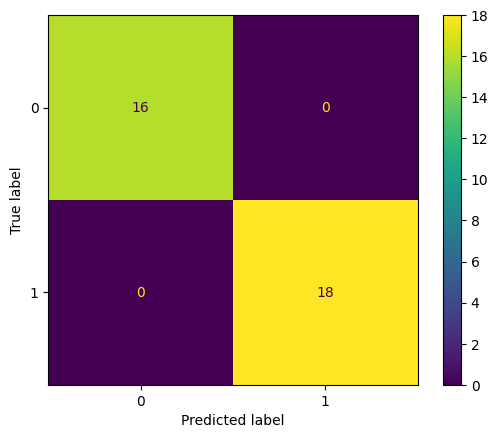

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [10]:
# Đánh giá model trên tập test
y_pred = rf_model.predict(X_test)

print("=== ĐÁNH GIÁ MODEL ===")
print("\nAccuracy:", rf_model.score(X_test, y_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Khac', 'Cao su']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

=== ĐÁNH GIÁ MODEL ===

Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

        Khac       1.00      1.00      1.00        16
      Cao su       1.00      1.00      1.00        18

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34


Confusion Matrix:
[[16  0]
 [ 0 18]]


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


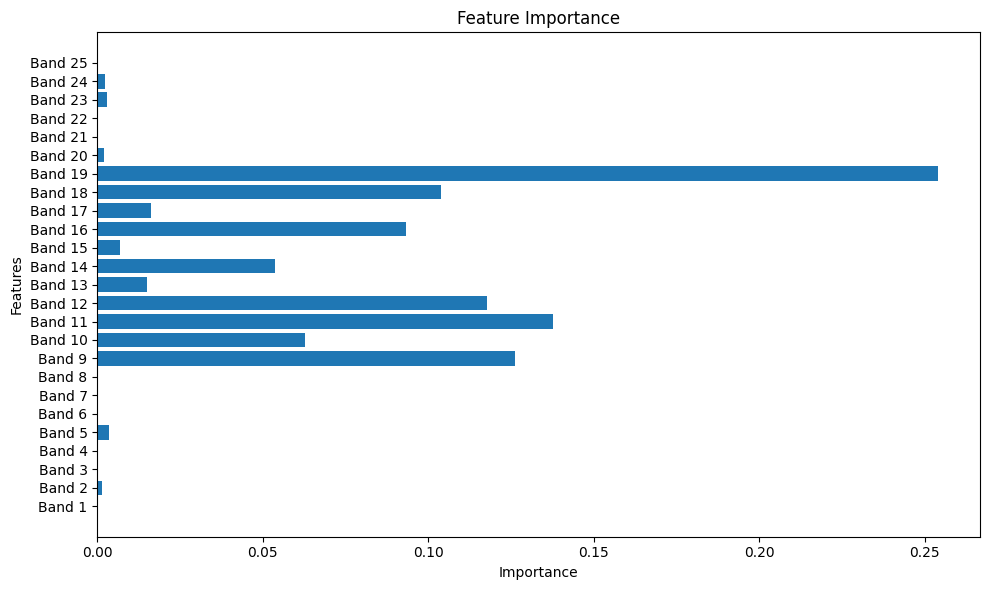


Top 10 most important features:
Band 19: 0.2540
Band 11: 0.1377
Band 9: 0.1262
Band 12: 0.1178
Band 18: 0.1038
Band 16: 0.0933
Band 10: 0.0628
Band 14: 0.0537
Band 17: 0.0161
Band 13: 0.0149


In [11]:
# Xem feature importance
import matplotlib.pyplot as plt

feature_importance = rf_model.feature_importances_
features = [f'Band {i+1}' for i in range(len(feature_importance))]

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# In ra top 10 features quan trọng nhất
sorted_idx = np.argsort(feature_importance)[::-1]
print("\nTop 10 most important features:")
for i in range(min(10, len(feature_importance))):
    idx = sorted_idx[i]
    print(f"{features[idx]}: {feature_importance[idx]:.4f}")

In [12]:
# Lưu model
output_dir = '../OUTPUT/train_model'
os.makedirs(output_dir, exist_ok=True)

model_path = os.path.join(output_dir, 'random_forest_model.pkl')
joblib.dump(rf_model, model_path)
print(f"Model đã được lưu tại: {model_path}")

# Lưu thông tin về model
model_info = {
    'n_features': X_train.shape[1],
    'n_samples_train': X_train.shape[0],
    'n_samples_test': X_test.shape[0],
    'accuracy': rf_model.score(X_test, y_test),
    'classes': ['Khac', 'Cao su']
}

import json
info_path = os.path.join(output_dir, 'model_info.json')
with open(info_path, 'w', encoding='utf-8') as f:
    json.dump(model_info, f, indent=4, ensure_ascii=False)
print(f"Thông tin model đã được lưu tại: {info_path}")

Model đã được lưu tại: ../OUTPUT/train_model\random_forest_model.pkl
Thông tin model đã được lưu tại: ../OUTPUT/train_model\model_info.json


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
